In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Eρώτηση 2.a. 

Ξεκινήστε χρησιμοποιώντας δυο επίπεδα συνέλιξης με 64 και 32 φίλτρα αντίστοιχα με μέγεθος
παραθύρου 3x3, και ένα fully connected επίπεδο με 128 νευρώνες. Μετά από κάθε συνελικτικό
επίπεδο χρησιμοποιείστε επίπεδο υποδειγματοληψίας (pooling), προτείνεται max pooling.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from matplotlib.pyplot import imread
from skimage.transform import resize
from keras.utils import to_categorical
import random
import pandas as pd 

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, MaxPool2D, Conv2D, Flatten
from keras.optimizers import Adam
from keras import backend as K

from keras.layers import BatchNormalization

## εισαγωγή Dataset

In [3]:
%cd "/content/drive/MyDrive/ergasia_anagnwrisi_draft"
!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset

/content/drive/MyDrive/ergasia_anagnwrisi_draft
fatal: destination path 'Sign-Language-Digits-Dataset' already exists and is not an empty directory.


In [4]:
# Settings:
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2


def get_img(data_path):
    # Getting image array from path:
    img = imread(data_path)
    img = resize(img, (img_size, img_size, 1 if grayscale_images else 3))
    return img


def get_dataset(dataset_path='/content/drive/MyDrive/ergasia_anagnwrisi_draft/Sign-Language-Digits-Dataset/Dataset'):
    # Getting all data from data path:
    try:
        X = np.load('npy_dataset/X.npy')
        Y = np.load('npy_dataset/Y.npy')
    except:
        labels = ['0','1','2','3','4','5','6','7','8','9']  # Geting labels
        X = []
        Y = []
        for i, label in enumerate(labels):
            datas_path = dataset_path + '/' + label
            for data in listdir(datas_path):
                img = get_img(datas_path + '/' + data)
                X.append(img)
                Y.append(i)
        # Create dateset:
        X = np.array(X).astype('float32')
        Y = np.array(Y).astype('float32')
        Y = to_categorical(Y, num_class)
        if not os.path.exists('npy_dataset/'):
            os.makedirs('npy_dataset/')
        np.save('npy_dataset/X.npy', X)
        np.save('npy_dataset/Y.npy', Y)
    return X, Y


if __name__ == '__main__':
    x, y = get_dataset()
    print('dataset shape: ',x.shape)
    print('labels shape: ',y.shape)

dataset shape:  (2062, 64, 64, 1)
labels shape:  (2062, 10)


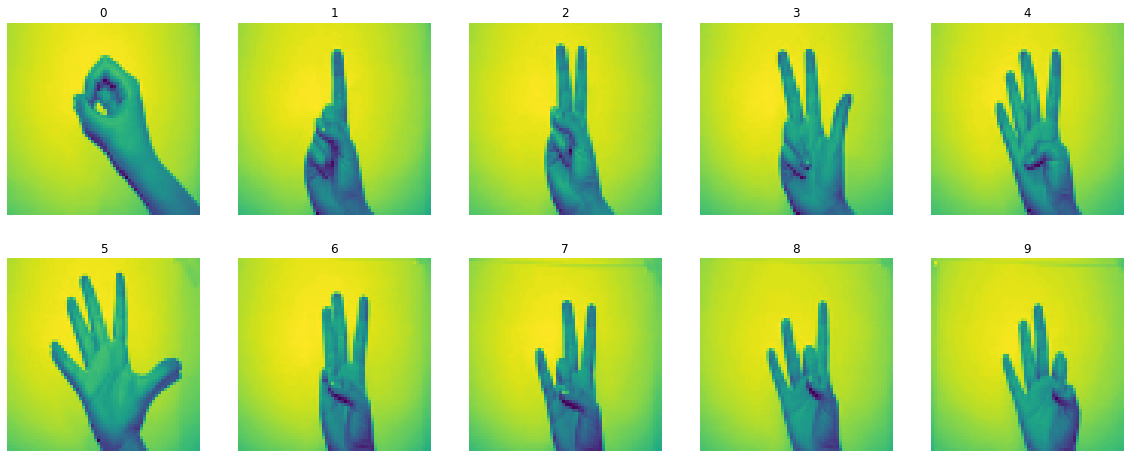

In [5]:
plt.figure(figsize=(20,6))

for i,j in enumerate([0,205,411,617,823,1030,1237,1444,1650,1858]):
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(top = 2, bottom = 1)
    plt.imshow(x[j].reshape(64,64))
    plt.title(np.argmax(y[j]))
    plt.axis('off')

In [6]:
x_train,x_val,Y_train,Y_val = train_test_split(x,y,test_size = 0.2,random_state = 42)
x_train,x_test,Y_train,Y_test = train_test_split(x_train,Y_train,test_size = 0.1,random_state = 42)


print("x_train shape:",x_train.shape)
print("x_val shape:",x_val.shape)
print("x_test shape:",x_test.shape)

x_train shape: (1484, 64, 64, 1)
x_val shape: (413, 64, 64, 1)
x_test shape: (165, 64, 64, 1)


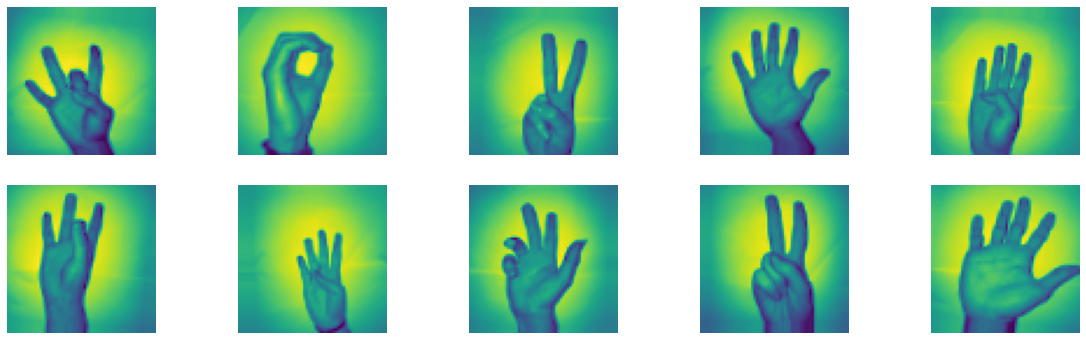

In [7]:
def show_new_samples(new_images):
    plt.figure(figsize=(20,6))
    for i in range(10):
        plt.subplot(2,5,i+1)
        image = new_images.next()
        plt.imshow(image[0].reshape(64,64))
        plt.axis('off')
    
    plt.show()

# Changing rotaion, zoom 
datagen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,height_shift_range=0.08, zoom_range=0.08)
new_images = datagen.flow(x_train,batch_size = 1)
datagen.fit(x_train)
show_new_samples(new_images)

## πρόταση Max Pooling 

###(2a1): Max pooling (2,2) 

In [8]:
model2a1 = Sequential()

model2a1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2a1.add(MaxPool2D(pool_size=(2,2)))
model2a1.add(Dropout(0.2))

model2a1.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2a1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2a1.add(Dropout(0.2))

model2a1.add(Flatten())
model2a1.add(Dropout(0.2))
model2a1.add(Dense(128, activation = "relu"))
model2a1.add(Dense(10, activation='softmax'))

model2a1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [9]:
from keras.callbacks import ModelCheckpoint

model2a1.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2a1 = model2a1.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 4s 41ms/step - loss: 2.3272 - accuracy: 0.0934 - val_loss: 2.3020 - val_accuracy: 0.1671

Epoch 00001: val_loss improved from inf to 2.30200, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 28ms/step - loss: 2.2905 - accuracy: 0.1241 - val_loss: 2.1181 - val_accuracy: 0.3559

Epoch 00002: val_loss improved from 2.30200 to 2.11812, saving model to weights.best.hdf5
Epoch 3/200
47/47 [==============================] - 1s 29ms/step - loss: 1.9473 - accuracy: 0.3391 - val_loss: 1.5016 - val_accuracy: 0.4939

Epoch 00003: val_loss improved from 2.11812 to 1.50160, saving model to weights.best.hdf5
Epoch 4/200
47/47 [==============================] - 1s 28ms/step - loss: 1.4458 - accuracy: 0.4935 - val_loss: 1.2417 - val_accuracy: 0.5981

Epoch 00004: val_loss improved from 1.50160 to 1.24165, saving model to weights.best.hdf5
Epoch 5/200
47/47 [==============================] - 1s 31ms/step - loss

In [10]:
best_score = min(history2a1.history['val_loss'])
best_epoch= history2a1.history['val_loss'].index(best_score)
best_val_acc=history2a1.history['val_accuracy'][best_epoch]
best_acc=history2a1.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  183
best epoch validation accuracy:  0.9757869243621826
best epoch train accuracy:  0.9818059206008911


###(2a2): Max pooling (3,3) 

In [11]:
model2a2 = Sequential()

model2a2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2a2.add(MaxPool2D(pool_size=(3,3)))
model2a2.add(Dropout(0.2))

model2a2.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2a2.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2a2.add(Dropout(0.2))

model2a2.add(Flatten())
model2a2.add(Dropout(0.2))
model2a2.add(Dense(128, activation = "relu"))
model2a2.add(Dense(10, activation='softmax'))

model2a2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)             

In [12]:
model2a2.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2a2 = model2a2.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 34ms/step - loss: 2.3152 - accuracy: 0.1231 - val_loss: 2.3018 - val_accuracy: 0.1065

Epoch 00001: val_loss improved from inf to 2.30181, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 29ms/step - loss: 2.2915 - accuracy: 0.1437 - val_loss: 2.1685 - val_accuracy: 0.2034

Epoch 00002: val_loss improved from 2.30181 to 2.16852, saving model to weights.best.hdf5
Epoch 3/200
47/47 [==============================] - 1s 29ms/step - loss: 2.0049 - accuracy: 0.3025 - val_loss: 1.5068 - val_accuracy: 0.4673

Epoch 00003: val_loss improved from 2.16852 to 1.50680, saving model to weights.best.hdf5
Epoch 4/200
47/47 [==============================] - 1s 30ms/step - loss: 1.4061 - accuracy: 0.4943 - val_loss: 1.3653 - val_accuracy: 0.5351

Epoch 00004: val_loss improved from 1.50680 to 1.36527, saving model to weights.best.hdf5
Epoch 5/200
47/47 [==============================] - 1s 29ms/step - loss

In [14]:
best_score = min(history2a2.history['val_loss'])
best_epoch= history2a2.history['val_loss'].index(best_score)
best_val_acc=history2a2.history['val_accuracy'][best_epoch]
best_acc=history2a2.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  180
best epoch validation accuracy:  0.9830508232116699
best epoch train accuracy:  0.9770889282226562


###(2a3): Max pooling (5,5) 

In [15]:
model2a3 = Sequential()

model2a3.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2a3.add(MaxPool2D(pool_size=(5,5)))
model2a3.add(Dropout(0.2))

model2a3.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2a3.add(MaxPool2D(pool_size=(5,5), strides=(5,5)))
model2a3.add(Dropout(0.2))

model2a3.add(Flatten())
model2a3.add(Dropout(0.2))
model2a3.add(Dense(128, activation = "relu"))
model2a3.add(Dense(10, activation='softmax'))

model2a3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

In [16]:
model2a3.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2a3 = model2a3.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 34ms/step - loss: 2.3211 - accuracy: 0.0956 - val_loss: 2.3038 - val_accuracy: 0.0823

Epoch 00001: val_loss improved from inf to 2.30384, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 28ms/step - loss: 2.2985 - accuracy: 0.1273 - val_loss: 2.2983 - val_accuracy: 0.1017

Epoch 00002: val_loss improved from 2.30384 to 2.29830, saving model to weights.best.hdf5
Epoch 3/200
47/47 [==============================] - 1s 30ms/step - loss: 2.2930 - accuracy: 0.1045 - val_loss: 2.2752 - val_accuracy: 0.1598

Epoch 00003: val_loss improved from 2.29830 to 2.27521, saving model to weights.best.hdf5
Epoch 4/200
47/47 [==============================] - 1s 30ms/step - loss: 2.2705 - accuracy: 0.1471 - val_loss: 2.2026 - val_accuracy: 0.2252

Epoch 00004: val_loss improved from 2.27521 to 2.20256, saving model to weights.best.hdf5
Epoch 5/200
47/47 [==============================] - 1s 29ms/step - loss

In [17]:
best_score = min(history2a3.history['val_loss'])
best_epoch= history2a3.history['val_loss'].index(best_score)
best_val_acc=history2a3.history['val_accuracy'][best_epoch]
best_acc=history2a3.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  199
best epoch validation accuracy:  0.9564164876937866
best epoch train accuracy:  0.9231805801391602


###(2a4): Max pooling (9,9) , Strides (3,3)

In [18]:
model2a4 = Sequential()

model2a4.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2a4.add(MaxPool2D(pool_size=(9,9), strides=(3,3)))
model2a4.add(Dropout(0.2))

model2a4.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2a4.add(MaxPool2D(pool_size=(9,9), strides=(3,3)))
model2a4.add(Dropout(0.2))

model2a4.add(Flatten())
model2a4.add(Dropout(0.2))
model2a4.add(Dense(128, activation = "relu"))
model2a4.add(Dense(10, activation='softmax'))

model2a4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 19, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)              

In [19]:
model2a4.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2a4 = model2a4.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 35ms/step - loss: 2.3279 - accuracy: 0.0922 - val_loss: 2.3054 - val_accuracy: 0.0920

Epoch 00001: val_loss improved from inf to 2.30537, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 30ms/step - loss: 2.3035 - accuracy: 0.1005 - val_loss: 2.2997 - val_accuracy: 0.1429

Epoch 00002: val_loss improved from 2.30537 to 2.29975, saving model to weights.best.hdf5
Epoch 3/200
47/47 [==============================] - 1s 30ms/step - loss: 2.2933 - accuracy: 0.1250 - val_loss: 2.2748 - val_accuracy: 0.2760

Epoch 00003: val_loss improved from 2.29975 to 2.27481, saving model to weights.best.hdf5
Epoch 4/200
47/47 [==============================] - 1s 29ms/step - loss: 2.2523 - accuracy: 0.1852 - val_loss: 2.1781 - val_accuracy: 0.2542

Epoch 00004: val_loss improved from 2.27481 to 2.17813, saving model to weights.best.hdf5
Epoch 5/200
47/47 [==============================] - 1s 29ms/step - loss

In [20]:
best_score = min(history2a4.history['val_loss'])
best_epoch= history2a4.history['val_loss'].index(best_score)
best_val_acc=history2a4.history['val_accuracy'][best_epoch]
best_acc=history2a4.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  188
best epoch validation accuracy:  0.9757869243621826
best epoch train accuracy:  0.973045825958252


# Ερώτηση 2.b.

Παραγωγή των γραφημάτων train/test – loss ανά εποχή. Εμφανίζεται το πρόβλημα
underfitting/overfitting; Αν ναι, να προτείνετε έναν τρόπο διαχείρισης του φαινομένου. Επίσης να
αιτιολογήσετε ποιος είναι ο βέλτιστος αριθμός εποχών εκπαίδευσης. Για τον βέλτιστο αριθμό
εποχών εκπαίδευσης, ζητείται να εξαχθούν οι μετρικές: accuracy, precision recall, f1 score, confusion
matrix.

In [21]:
model2b = Sequential()

model2b.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2b.add(MaxPool2D(pool_size=(3,3)))
model2b.add(Dropout(0.2))

model2b.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2b.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2b.add(Dropout(0.2))

model2b.add(Flatten())
model2b.add(Dropout(0.2))
model2b.add(Dense(128, activation = "relu"))
model2b.add(Dense(10, activation='softmax'))

model2b.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 32)        18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1568)             

In [22]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model2b.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy",f1_m,precision_m, recall_m])
history2b = model2b.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 3s 37ms/step - loss: 2.3174 - accuracy: 0.1088 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.3026 - val_accuracy: 0.0872 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.30257, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 32ms/step - loss: 2.2942 - accuracy: 0.1238 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.2206 - val_accuracy: 0.2276 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00

Epoch 00002: val_loss improved from 2.30257 to 2.22057, saving model to weights.best.hdf5
Epoch 3/200
47/47 [==============================] - 1s 30ms/step - loss: 2.1011 - accuracy: 0.2561 - f1_m: 0.0122 - precision_m: 0.0873 - recall_m: 0.0068 - val_loss: 1.5346 - val_accuracy: 0.5327 - val_f1_m: 0.1043 - val_precision_m: 0.9359

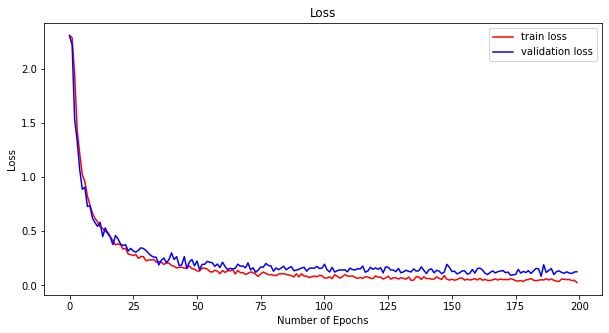

In [24]:
plt.figure(figsize = (10,5))
plt.plot(history2b.history['loss'],color='r',label="train loss")
plt.plot(history2b.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
best_score = min(history2b.history['val_loss'])
best_epoch= history2b.history['val_loss'].index(best_score)
best_val_acc=history2b.history['val_accuracy'][best_epoch]
best_acc=history2b.history['accuracy'][best_epoch]
best_precision=history2b.history['precision_m'][best_epoch]
best_recall=history2b.history['recall_m'][best_epoch]
best_f1=history2b.history['f1_m'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)
print('best epoch precision: ',best_precision)
print('best epoch recall: ',best_recall)
print('best epoch f1: ',best_f1)

best epoch:  185
best epoch validation accuracy:  0.9854721426963806
best epoch train accuracy:  0.9838274717330933
best epoch precision:  0.9846002459526062
best epoch recall:  0.9820478558540344
best epoch f1:  0.983292818069458


In [26]:
#evaluate the network 
score = model2b.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 7ms/step - loss: 0.3444 - accuracy: 0.9697 - f1_m: 0.9740 - precision_m: 0.9740 - recall_m: 0.9740
Test score:  0.3443743586540222
Test accuracy:  0.9696969985961914


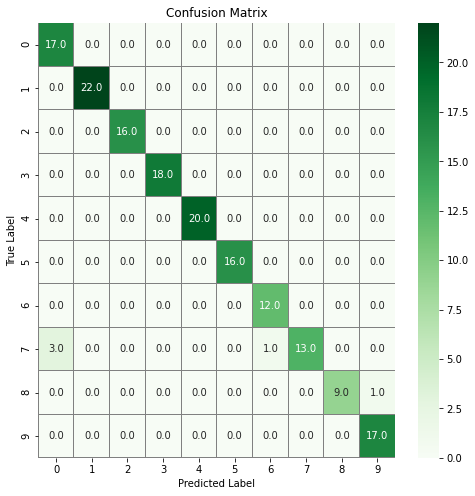

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the values from the validation dataset
Y_pred = model2b.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Ερώτηση 2.c.

Υλοποιήστε διάφορες δομές συνελικτικών τεχνητών νευρωνικών δικτύων και μεταβλητού αριθμού
νευρώνων

##(2c1): 2 convolutional (32,64), 1 fully connected(128) 

In [28]:
model2c1 = Sequential()

model2c1.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2c1.add(MaxPool2D(pool_size=(3,3)))
model2c1.add(Dropout(0.2))

model2c1.add(Conv2D(filters = 64 , kernel_size = (5,5),padding = 'Same',activation ='relu'))
model2c1.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model2c1.add(Dropout(0.2))

model2c1.add(Flatten())
model2c1.add(Dropout(0.2))
model2c1.add(Dense(128, activation = "relu"))
model2c1.add(Dense(10, activation='softmax'))

model2c1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6400)             

In [29]:
model2c1.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2c1 = model2c1.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 33ms/step - loss: 2.3354 - accuracy: 0.1204 - val_loss: 2.3052 - val_accuracy: 0.0775

Epoch 00001: val_loss improved from inf to 2.30518, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 29ms/step - loss: 2.2953 - accuracy: 0.1283 - val_loss: 2.1877 - val_accuracy: 0.3462

Epoch 00002: val_loss improved from 2.30518 to 2.18768, saving model to weights.best.hdf5
Epoch 3/200
47/47 [==============================] - 1s 29ms/step - loss: 2.0010 - accuracy: 0.3278 - val_loss: 1.3479 - val_accuracy: 0.5787

Epoch 00003: val_loss improved from 2.18768 to 1.34791, saving model to weights.best.hdf5
Epoch 4/200
47/47 [==============================] - 1s 30ms/step - loss: 1.3490 - accuracy: 0.5201 - val_loss: 1.0331 - val_accuracy: 0.6659

Epoch 00004: val_loss improved from 1.34791 to 1.03311, saving model to weights.best.hdf5
Epoch 5/200
47/47 [==============================] - 1s 29ms/step - loss

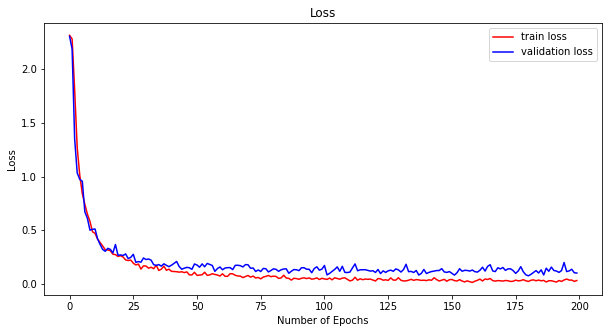

In [30]:
plt.figure(figsize = (10,5))
plt.plot(history2c1.history['loss'],color='r',label="train loss")
plt.plot(history2c1.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [31]:
best_score = min(history2c1.history['val_loss'])
best_epoch= history2c1.history['val_loss'].index(best_score)
best_val_acc=history2c1.history['val_accuracy'][best_epoch]
best_acc=history2c1.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  180
best epoch validation accuracy:  0.990314781665802
best epoch train accuracy:  0.9946091771125793


In [32]:
#evaluate the network 
score = model2c1.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 6ms/step - loss: 0.1939 - accuracy: 0.9818
Test score:  0.19389010965824127
Test accuracy:  0.9818181991577148


##(2c2): 2 convolutional (32,64), 2 fully connected(128,64) 

In [33]:
model2c2 = Sequential()

model2c2.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2c2.add(MaxPool2D(pool_size=(3,3)))
model2c2.add(Dropout(0.2))

model2c2.add(Conv2D(filters = 64 , kernel_size = (5,5),padding = 'Same',activation ='relu'))
model2c2.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model2c2.add(Dropout(0.2))

model2c2.add(Flatten())
model2c2.add(Dropout(0.2))
model2c2.add(Dense(128, activation = "relu"))
model2c2.add(Dense(64, activation = "relu"))
model2c2.add(Dense(10, activation='softmax'))

model2c2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6400)             

In [34]:
model2c2.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2c2 = model2c2.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 33ms/step - loss: 2.3208 - accuracy: 0.0946 - val_loss: 2.3030 - val_accuracy: 0.1211

Epoch 00001: val_loss improved from inf to 2.30298, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 29ms/step - loss: 2.3022 - accuracy: 0.0993 - val_loss: 2.3112 - val_accuracy: 0.0847

Epoch 00002: val_loss did not improve from 2.30298
Epoch 3/200
47/47 [==============================] - 1s 28ms/step - loss: 2.2870 - accuracy: 0.1480 - val_loss: 2.1127 - val_accuracy: 0.1792

Epoch 00003: val_loss improved from 2.30298 to 2.11271, saving model to weights.best.hdf5
Epoch 4/200
47/47 [==============================] - 1s 29ms/step - loss: 1.9580 - accuracy: 0.2948 - val_loss: 1.5104 - val_accuracy: 0.4649

Epoch 00004: val_loss improved from 2.11271 to 1.51044, saving model to weights.best.hdf5
Epoch 5/200
47/47 [==============================] - 1s 29ms/step - loss: 1.3586 - accuracy: 0.5228 - val_loss:

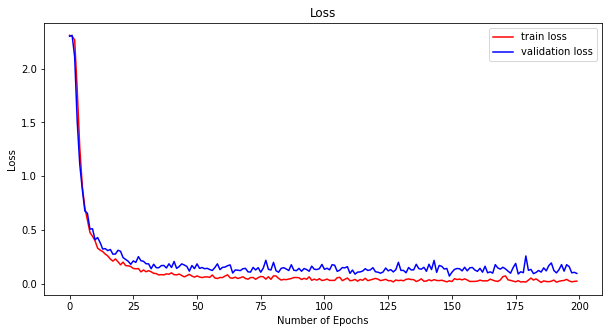

In [35]:
plt.figure(figsize = (10,5))
plt.plot(history2c2.history['loss'],color='r',label="train loss")
plt.plot(history2c2.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
best_score = min(history2c2.history['val_loss'])
best_epoch= history2c2.history['val_loss'].index(best_score)
best_val_acc=history2c2.history['val_accuracy'][best_epoch]
best_acc=history2c2.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  149
best epoch validation accuracy:  0.990314781665802
best epoch train accuracy:  0.9912399053573608


In [37]:
#evaluate the network 
score = model2c2.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 4ms/step - loss: 0.1406 - accuracy: 0.9758
Test score:  0.14056046307086945
Test accuracy:  0.9757575988769531


##(2c3): 4 convolutional (32,32,64,64), 2 fully connected(64,128) 

In [38]:
model2c3 = Sequential()

model2c3.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2c3.add(MaxPool2D(pool_size=(3,3)))
model2c3.add(Dropout(0.2))

model2c3.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2c3.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2c3.add(Dropout(0.2))

model2c3.add(Conv2D(filters = 64 , kernel_size = (5,5),padding = 'Same',activation ='relu'))
model2c3.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model2c3.add(Dropout(0.2))

model2c3.add(Conv2D(filters = 64 , kernel_size = (5,5),padding = 'Same',activation ='relu'))
model2c3.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model2c3.add(Dropout(0.2))

model2c3.add(Flatten())
model2c3.add(Dropout(0.2))
model2c3.add(Dense(64, activation = "relu"))
model2c3.add(Dense(128, activation = "relu"))
model2c3.add(Dense(10, activation='softmax'))

model2c3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 64)         

In [39]:
model2c3.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2c3 = model2c3.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 35ms/step - loss: 2.3063 - accuracy: 0.1060 - val_loss: 2.3035 - val_accuracy: 0.0775

Epoch 00001: val_loss improved from inf to 2.30353, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 29ms/step - loss: 2.3022 - accuracy: 0.0907 - val_loss: 2.3051 - val_accuracy: 0.0775

Epoch 00002: val_loss did not improve from 2.30353
Epoch 3/200
47/47 [==============================] - 1s 30ms/step - loss: 2.3007 - accuracy: 0.1074 - val_loss: 2.3057 - val_accuracy: 0.0775

Epoch 00003: val_loss did not improve from 2.30353
Epoch 4/200
47/47 [==============================] - 1s 31ms/step - loss: 2.3019 - accuracy: 0.1012 - val_loss: 2.3057 - val_accuracy: 0.1090

Epoch 00004: val_loss did not improve from 2.30353
Epoch 5/200
47/47 [==============================] - 2s 32ms/step - loss: 2.3026 - accuracy: 0.1084 - val_loss: 2.3063 - val_accuracy: 0.0775

Epoch 00005: val_loss did not improve from 2.3

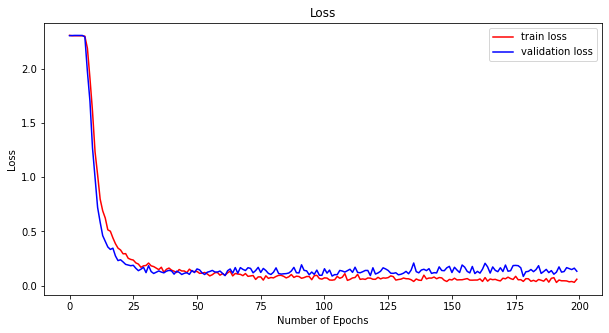

In [40]:
plt.figure(figsize = (10,5))
plt.plot(history2c3.history['loss'],color='r',label="train loss")
plt.plot(history2c3.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [41]:
best_score = min(history2c3.history['val_loss'])
best_epoch= history2c3.history['val_loss'].index(best_score)
best_val_acc=history2c3.history['val_accuracy'][best_epoch]
best_acc=history2c3.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  178
best epoch validation accuracy:  0.9878934621810913
best epoch train accuracy:  0.9858490824699402


In [42]:
#evaluate the network 
score = model2c3.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 7ms/step - loss: 0.1720 - accuracy: 0.9758
Test score:  0.17204029858112335
Test accuracy:  0.9757575988769531


##(2c4): 3 convolutional (32,64,128), 1 fully connected(256) 

In [43]:
model2c4 = Sequential()

model2c4.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2c4.add(MaxPool2D(pool_size=(3,3)))
model2c4.add(Dropout(0.2))

model2c4.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2c4.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2c4.add(Dropout(0.2))

model2c4.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2c4.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2c4.add(Dropout(0.2))

model2c4.add(Flatten())
model2c4.add(Dropout(0.2))
model2c4.add(Dense(256, activation = "relu"))
model2c4.add(Dense(10, activation='softmax'))

model2c4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 128)        

In [44]:
model2c4.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2c4 = model2c4.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 33ms/step - loss: 2.3047 - accuracy: 0.1070 - val_loss: 2.2993 - val_accuracy: 0.0993

Epoch 00001: val_loss improved from inf to 2.29932, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 2s 32ms/step - loss: 2.2885 - accuracy: 0.1245 - val_loss: 2.1311 - val_accuracy: 0.3196

Epoch 00002: val_loss improved from 2.29932 to 2.13111, saving model to weights.best.hdf5
Epoch 3/200
47/47 [==============================] - 1s 28ms/step - loss: 1.9788 - accuracy: 0.3034 - val_loss: 1.0467 - val_accuracy: 0.6610

Epoch 00003: val_loss improved from 2.13111 to 1.04671, saving model to weights.best.hdf5
Epoch 4/200
47/47 [==============================] - 1s 30ms/step - loss: 1.1723 - accuracy: 0.5881 - val_loss: 0.6214 - val_accuracy: 0.8039

Epoch 00004: val_loss improved from 1.04671 to 0.62138, saving model to weights.best.hdf5
Epoch 5/200
47/47 [==============================] - 1s 28ms/step - loss

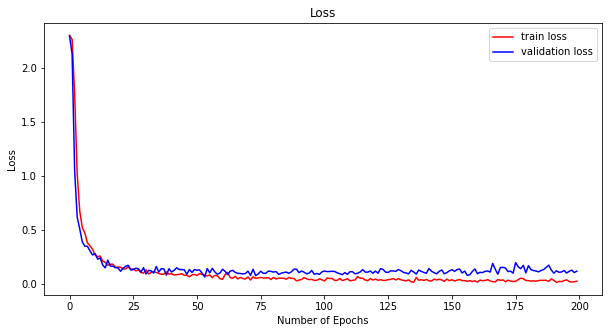

In [45]:
plt.figure(figsize = (10,5))
plt.plot(history2c4.history['loss'],color='r',label="train loss")
plt.plot(history2c4.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [46]:
best_score = min(history2c4.history['val_loss'])
best_epoch= history2c4.history['val_loss'].index(best_score)
best_val_acc=history2c4.history['val_accuracy'][best_epoch]
best_acc=history2c4.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  53
best epoch validation accuracy:  0.9830508232116699
best epoch train accuracy:  0.9743935465812683


In [47]:
#evaluate the network 
score = model2c4.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 6ms/step - loss: 0.4553 - accuracy: 0.9818
Test score:  0.4553130567073822
Test accuracy:  0.9818181991577148


##(2c5): 3 convolutional (32,64,128), 1 fully connected(128) 

In [48]:
model2c5 = Sequential()

model2c5.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2c5.add(MaxPool2D(pool_size=(3,3)))
model2c5.add(Dropout(0.2))

model2c5.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2c5.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2c5.add(Dropout(0.2))

model2c5.add(Conv2D(filters = 128 , kernel_size = (5,5),padding = 'Same',activation ='relu'))
model2c5.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model2c5.add(Dropout(0.2))

model2c5.add(Flatten())
model2c5.add(Dropout(0.2))
model2c5.add(Dense(128, activation = "relu"))
model2c5.add(Dense(10, activation='softmax'))

model2c5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 128)        

In [49]:
model2c5.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2c5 = model2c5.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 33ms/step - loss: 2.3249 - accuracy: 0.0856 - val_loss: 2.3033 - val_accuracy: 0.0993

Epoch 00001: val_loss improved from inf to 2.30328, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 28ms/step - loss: 2.3023 - accuracy: 0.0988 - val_loss: 2.3025 - val_accuracy: 0.1090

Epoch 00002: val_loss improved from 2.30328 to 2.30248, saving model to weights.best.hdf5
Epoch 3/200
47/47 [==============================] - 1s 30ms/step - loss: 2.2990 - accuracy: 0.1159 - val_loss: 2.2765 - val_accuracy: 0.1017

Epoch 00003: val_loss improved from 2.30248 to 2.27648, saving model to weights.best.hdf5
Epoch 4/200
47/47 [==============================] - 1s 30ms/step - loss: 2.2299 - accuracy: 0.1622 - val_loss: 1.8241 - val_accuracy: 0.3898

Epoch 00004: val_loss improved from 2.27648 to 1.82413, saving model to weights.best.hdf5
Epoch 5/200
47/47 [==============================] - 1s 29ms/step - loss

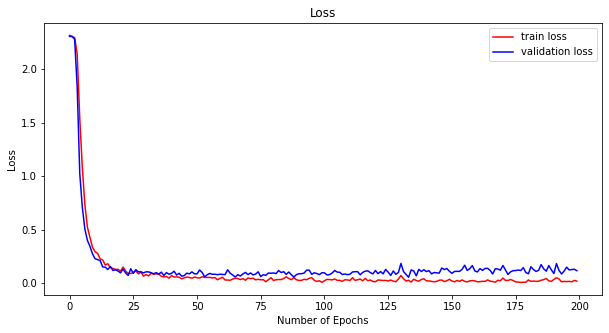

In [50]:
plt.figure(figsize = (10,5))
plt.plot(history2c5.history['loss'],color='r',label="train loss")
plt.plot(history2c5.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [51]:
best_score = min(history2c5.history['val_loss'])
best_epoch= history2c5.history['val_loss'].index(best_score)
best_val_acc=history2c5.history['val_accuracy'][best_epoch]
best_acc=history2c5.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  133
best epoch validation accuracy:  0.9975786805152893
best epoch train accuracy:  0.9925876259803772


In [52]:
#evaluate the network 
score = model2c5.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 6ms/step - loss: 0.3268 - accuracy: 0.9758
Test score:  0.3268011808395386
Test accuracy:  0.9757575988769531


##(2c6): 4 convolutional (32,64,128,256), 1 fully connected(256) 

In [53]:
model2c6 = Sequential()

model2c6.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2c6.add(MaxPool2D(pool_size=(3,3)))
model2c6.add(Dropout(0.2))

model2c6.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2c6.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2c6.add(Dropout(0.2))

model2c6.add(Conv2D(filters = 128 , kernel_size = (5,5),padding = 'Same',activation ='relu'))
model2c6.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model2c6.add(Dropout(0.2))

model2c6.add(Conv2D(filters = 256 , kernel_size = (5,5),padding = 'Same',activation ='relu'))
model2c6.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model2c6.add(Dropout(0.2))

model2c6.add(Flatten())
model2c6.add(Dropout(0.2))
model2c6.add(Dense(128, activation = "relu"))
model2c6.add(Dense(10, activation='softmax'))

model2c6.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 128)       

In [54]:
model2c6.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2c6 = model2c6.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 32ms/step - loss: 2.3208 - accuracy: 0.0926 - val_loss: 2.3041 - val_accuracy: 0.0654

Epoch 00001: val_loss improved from inf to 2.30410, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 29ms/step - loss: 2.3025 - accuracy: 0.1066 - val_loss: 2.3046 - val_accuracy: 0.0847

Epoch 00002: val_loss did not improve from 2.30410
Epoch 3/200
47/47 [==============================] - 1s 30ms/step - loss: 2.3037 - accuracy: 0.0988 - val_loss: 2.3062 - val_accuracy: 0.0775

Epoch 00003: val_loss did not improve from 2.30410
Epoch 4/200
47/47 [==============================] - 1s 27ms/step - loss: 2.3035 - accuracy: 0.1016 - val_loss: 2.3063 - val_accuracy: 0.0775

Epoch 00004: val_loss did not improve from 2.30410
Epoch 5/200
47/47 [==============================] - 1s 28ms/step - loss: 2.3015 - accuracy: 0.0986 - val_loss: 2.3064 - val_accuracy: 0.0775

Epoch 00005: val_loss did not improve from 2.3

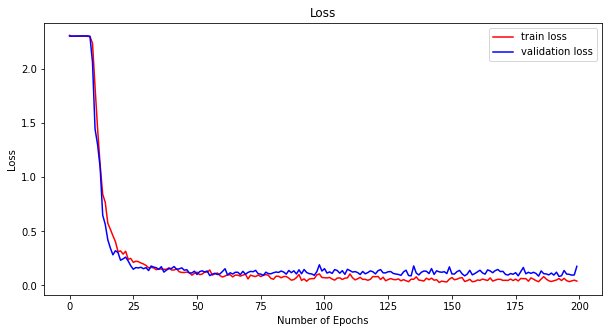

In [55]:
plt.figure(figsize = (10,5))
plt.plot(history2c6.history['loss'],color='r',label="train loss")
plt.plot(history2c6.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [56]:
best_score = min(history2c6.history['val_loss'])
best_epoch= history2c6.history['val_loss'].index(best_score)
best_val_acc=history2c6.history['val_accuracy'][best_epoch]
best_acc=history2c6.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  192
best epoch validation accuracy:  0.9951573610305786
best epoch train accuracy:  0.9838274717330933


In [57]:
#evaluate the network 
score = model2c6.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 8ms/step - loss: 0.2309 - accuracy: 0.9697
Test score:  0.2309095710515976
Test accuracy:  0.9696969985961914


##(2c7): 3 convolutional (32,64,128), 1 fully connected(64) 

In [58]:
model2c7 = Sequential()

model2c7.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2c7.add(MaxPool2D(pool_size=(3,3)))
model2c7.add(Dropout(0.2))

model2c7.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2c7.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2c7.add(Dropout(0.2))

model2c7.add(Conv2D(filters = 128 , kernel_size = (5,5),padding = 'Same',activation ='relu'))
model2c7.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model2c7.add(Dropout(0.2))

model2c7.add(Flatten())
model2c7.add(Dropout(0.2))
model2c7.add(Dense(64, activation = "relu"))
model2c7.add(Dense(10, activation='softmax'))

model2c7.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 128)       

In [59]:
model2c7.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2c7 = model2c7.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 33ms/step - loss: 2.3040 - accuracy: 0.1225 - val_loss: 2.3044 - val_accuracy: 0.0775

Epoch 00001: val_loss improved from inf to 2.30443, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 28ms/step - loss: 2.3032 - accuracy: 0.1134 - val_loss: 2.3034 - val_accuracy: 0.1090

Epoch 00002: val_loss improved from 2.30443 to 2.30344, saving model to weights.best.hdf5
Epoch 3/200
47/47 [==============================] - 1s 28ms/step - loss: 2.3029 - accuracy: 0.1000 - val_loss: 2.3041 - val_accuracy: 0.0775

Epoch 00003: val_loss did not improve from 2.30344
Epoch 4/200
47/47 [==============================] - 1s 28ms/step - loss: 2.3018 - accuracy: 0.1080 - val_loss: 2.3041 - val_accuracy: 0.1090

Epoch 00004: val_loss did not improve from 2.30344
Epoch 5/200
47/47 [==============================] - 1s 29ms/step - loss: 2.3009 - accuracy: 0.1059 - val_loss: 2.2932 - val_accuracy: 0.1743

Epoch 0

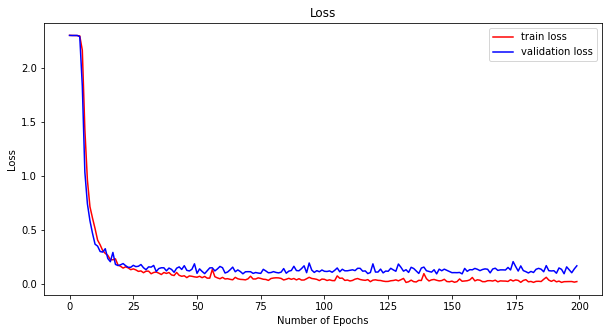

In [60]:
plt.figure(figsize = (10,5))
plt.plot(history2c7.history['loss'],color='r',label="train loss")
plt.plot(history2c7.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [61]:
best_score = min(history2c7.history['val_loss'])
best_epoch= history2c7.history['val_loss'].index(best_score)
best_val_acc=history2c7.history['val_accuracy'][best_epoch]
best_acc=history2c7.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  144
best epoch validation accuracy:  0.9927361011505127
best epoch train accuracy:  0.9885444641113281


In [62]:
#evaluate the network 
score = model2c7.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 4ms/step - loss: 0.3832 - accuracy: 0.9818
Test score:  0.38323402404785156
Test accuracy:  0.9818181991577148


##(2c8): 3 convolutional (16,32,64), 1 fully connected(128) 

In [63]:
model2c8 = Sequential()

model2c8.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2c8.add(MaxPool2D(pool_size=(3,3)))
model2c8.add(Dropout(0.2))

model2c8.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2c8.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2c8.add(Dropout(0.2))

model2c8.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2c8.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2c8.add(Dropout(0.2))

model2c8.add(Flatten())
model2c8.add(Dropout(0.2))
model2c8.add(Dense(128, activation = "relu"))
model2c8.add(Dense(10, activation='softmax'))

model2c8.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 7, 64)        

In [64]:
model2c8.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2c8 = model2c8.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 30ms/step - loss: 2.3217 - accuracy: 0.0993 - val_loss: 2.3022 - val_accuracy: 0.0993

Epoch 00001: val_loss improved from inf to 2.30222, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 27ms/step - loss: 2.3023 - accuracy: 0.1125 - val_loss: 2.3039 - val_accuracy: 0.0799

Epoch 00002: val_loss did not improve from 2.30222
Epoch 3/200
47/47 [==============================] - 1s 25ms/step - loss: 2.3008 - accuracy: 0.1220 - val_loss: 2.3037 - val_accuracy: 0.1162

Epoch 00003: val_loss did not improve from 2.30222
Epoch 4/200
47/47 [==============================] - 1s 26ms/step - loss: 2.3002 - accuracy: 0.1024 - val_loss: 2.3033 - val_accuracy: 0.1065

Epoch 00004: val_loss did not improve from 2.30222
Epoch 5/200
47/47 [==============================] - 1s 26ms/step - loss: 2.2946 - accuracy: 0.1174 - val_loss: 2.2851 - val_accuracy: 0.1404

Epoch 00005: val_loss improved from 2.30222 to

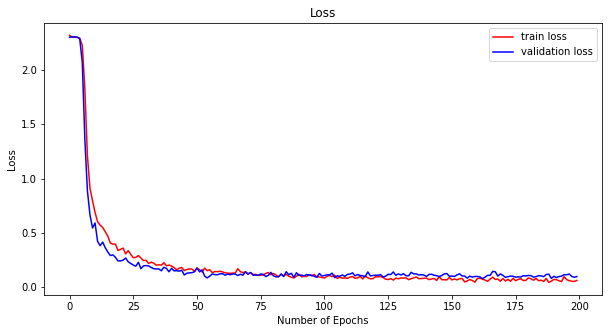

In [65]:
plt.figure(figsize = (10,5))
plt.plot(history2c8.history['loss'],color='r',label="train loss")
plt.plot(history2c8.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [66]:
best_score = min(history2c8.history['val_loss'])
best_epoch= history2c8.history['val_loss'].index(best_score)
best_val_acc=history2c8.history['val_accuracy'][best_epoch]
best_acc=history2c8.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  162
best epoch validation accuracy:  0.9878934621810913
best epoch train accuracy:  0.9743935465812683


In [67]:
#evaluate the network 
score = model2c8.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 8ms/step - loss: 0.1904 - accuracy: 0.9697
Test score:  0.19038546085357666
Test accuracy:  0.9696969985961914


##(2c9): 3 convolutional (16,32,64), 1 fully connected(256) 

In [68]:
model2c9 = Sequential()

model2c9.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2c9.add(MaxPool2D(pool_size=(3,3)))
model2c9.add(Dropout(0.2))

model2c9.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2c9.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2c9.add(Dropout(0.2))

model2c9.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2c9.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2c9.add(Dropout(0.2))

model2c9.add(Flatten())
model2c9.add(Dropout(0.2))
model2c9.add(Dense(256, activation = "relu"))
model2c9.add(Dense(10, activation='softmax'))

model2c9.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 7, 7, 64)        

In [69]:
model2c9.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2c9 = model2c9.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 30ms/step - loss: 2.3236 - accuracy: 0.1083 - val_loss: 2.3020 - val_accuracy: 0.0993

Epoch 00001: val_loss improved from inf to 2.30196, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 25ms/step - loss: 2.3034 - accuracy: 0.1195 - val_loss: 2.3034 - val_accuracy: 0.0993

Epoch 00002: val_loss did not improve from 2.30196
Epoch 3/200
47/47 [==============================] - 1s 25ms/step - loss: 2.3007 - accuracy: 0.0974 - val_loss: 2.3022 - val_accuracy: 0.0920

Epoch 00003: val_loss did not improve from 2.30196
Epoch 4/200
47/47 [==============================] - 1s 25ms/step - loss: 2.2974 - accuracy: 0.1069 - val_loss: 2.2944 - val_accuracy: 0.1211

Epoch 00004: val_loss improved from 2.30196 to 2.29443, saving model to weights.best.hdf5
Epoch 5/200
47/47 [==============================] - 1s 26ms/step - loss: 2.2833 - accuracy: 0.1317 - val_loss: 2.1767 - val_accuracy: 0.1985

Epoch 0

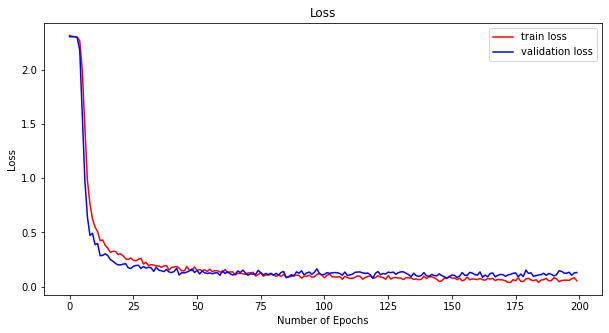

In [70]:
plt.figure(figsize = (10,5))
plt.plot(history2c9.history['loss'],color='r',label="train loss")
plt.plot(history2c9.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [71]:
best_score = min(history2c9.history['val_loss'])
best_epoch= history2c9.history['val_loss'].index(best_score)
best_val_acc=history2c9.history['val_accuracy'][best_epoch]
best_acc=history2c9.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  119
best epoch validation accuracy:  0.990314781665802
best epoch train accuracy:  0.9710242748260498


In [72]:
#evaluate the network 
score = model2c9.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 4ms/step - loss: 0.2968 - accuracy: 0.9697
Test score:  0.296781450510025
Test accuracy:  0.9696969985961914


##(2cA): 4 convolutional (16,32,32,64), 1 fully connected(128) 

In [73]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPool2D, Conv2D, Flatten
from keras.optimizers import Adam

In [74]:
model2cA = Sequential()
model2cA.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model2cA.add(MaxPool2D(pool_size=(3,3)))
model2cA.add(Dropout(0.2))

model2cA.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2cA.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2cA.add(Dropout(0.2))

model2cA.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2cA.add(MaxPool2D(pool_size=(3,3)))
model2cA.add(Dropout(0.2))

model2cA.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model2cA.add(MaxPool2D(pool_size=(2,2)))
model2cA.add(Dropout(0.2))

model2cA.add(Flatten())
model2cA.add(Dropout(0.2))
model2cA.add(Dense(128, activation = "relu"))
model2cA.add(Dense(10, activation='softmax'))

model2cA.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 7, 7, 32)        

In [75]:
model2cA.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2cA = model2cA.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 2s 31ms/step - loss: 2.3140 - accuracy: 0.0956 - val_loss: 2.3044 - val_accuracy: 0.0920

Epoch 00001: val_loss improved from inf to 2.30442, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 27ms/step - loss: 2.3017 - accuracy: 0.1122 - val_loss: 2.3047 - val_accuracy: 0.0847

Epoch 00002: val_loss did not improve from 2.30442
Epoch 3/200
47/47 [==============================] - 1s 27ms/step - loss: 2.3016 - accuracy: 0.0948 - val_loss: 2.3031 - val_accuracy: 0.0872

Epoch 00003: val_loss improved from 2.30442 to 2.30313, saving model to weights.best.hdf5
Epoch 4/200
47/47 [==============================] - 1s 26ms/step - loss: 2.2986 - accuracy: 0.1017 - val_loss: 2.2967 - val_accuracy: 0.1889

Epoch 00004: val_loss improved from 2.30313 to 2.29668, saving model to weights.best.hdf5
Epoch 5/200
47/47 [==============================] - 1s 29ms/step - loss: 2.2828 - accuracy: 0.1273 - val_loss:

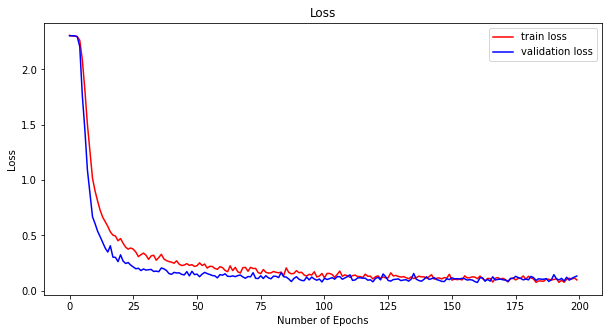

In [76]:
plt.figure(figsize = (10,5))
plt.plot(history2cA.history['loss'],color='r',label="train loss")
plt.plot(history2cA.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [77]:
best_score = min(history2cA.history['val_loss'])
best_epoch= history2cA.history['val_loss'].index(best_score)
best_val_acc=history2cA.history['val_accuracy'][best_epoch]
best_acc=history2cA.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  160
best epoch validation accuracy:  0.990314781665802
best epoch train accuracy:  0.9649595618247986


In [78]:
#evaluate the network 
score = model2cA.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 7ms/step - loss: 0.2623 - accuracy: 0.9818
Test score:  0.26232099533081055
Test accuracy:  0.9818181991577148


# Ερώτηση 2.d.

CNN tuning: Χρησιμοποιείστε κανονικοποίηση των δεδομένων σας (batch normalization). Τι
επίδραση έχει στην ακρίβεια;

In [80]:
model2d = Sequential()

model2d.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', input_shape = (64,64,1)))
model2d.add(BatchNormalization())
model2d.add(Activation('relu'))
model2d.add(MaxPool2D(pool_size=(3,3)))
model2d.add(Dropout(0.2))

model2d.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same'))
model2d.add(BatchNormalization())
model2d.add(Activation('relu'))
model2d.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2d.add(Dropout(0.2))

model2d.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same'))
model2d.add(BatchNormalization())
model2d.add(Activation('relu'))
model2d.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2d.add(Dropout(0.2))

model2d.add(Flatten())
model2d.add(Dropout(0.2))
model2d.add(Dense(128))
model2d.add(Activation('relu'))
model2d.add(BatchNormalization())

model2d.add(Dense(10, activation='softmax'))

model2d.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 64)      

In [81]:
model2d.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2d = model2d.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 3s 36ms/step - loss: 2.6804 - accuracy: 0.1495 - val_loss: 2.3061 - val_accuracy: 0.1114

Epoch 00001: val_loss improved from inf to 2.30611, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 29ms/step - loss: 1.7099 - accuracy: 0.3851 - val_loss: 2.4619 - val_accuracy: 0.0993

Epoch 00002: val_loss did not improve from 2.30611
Epoch 3/200
47/47 [==============================] - 1s 31ms/step - loss: 1.1209 - accuracy: 0.6171 - val_loss: 2.6196 - val_accuracy: 0.0775

Epoch 00003: val_loss did not improve from 2.30611
Epoch 4/200
47/47 [==============================] - 1s 29ms/step - loss: 0.8741 - accuracy: 0.7027 - val_loss: 2.7986 - val_accuracy: 0.0775

Epoch 00004: val_loss did not improve from 2.30611
Epoch 5/200
47/47 [==============================] - 1s 30ms/step - loss: 0.6995 - accuracy: 0.7755 - val_loss: 2.8809 - val_accuracy: 0.0775

Epoch 00005: val_loss did not improve from 2.3

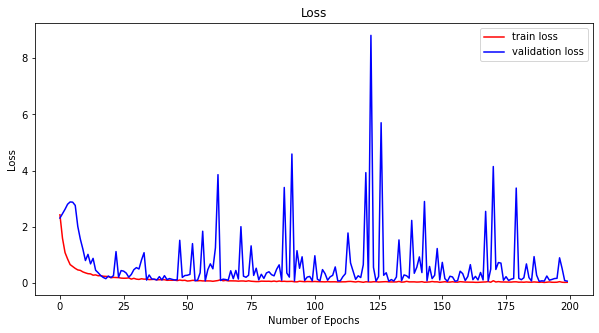

In [82]:
plt.figure(figsize = (10,5))
plt.plot(history2d.history['loss'],color='r',label="train loss")
plt.plot(history2d.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [83]:
best_score = min(history2d.history['val_loss'])
best_epoch= history2d.history['val_loss'].index(best_score)
best_val_acc=history2d.history['val_accuracy'][best_epoch]
best_acc=history2d.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  188
best epoch validation accuracy:  0.9878934621810913
best epoch train accuracy:  0.9939352869987488


In [84]:
#evaluate the network 
score = model2d.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 7ms/step - loss: 0.2848 - accuracy: 0.9818
Test score:  0.2848461866378784
Test accuracy:  0.9818181991577148


# ερώτηση 2.e.

Δοκιμάστε αρχιτεκτονική CNN χωρίς fully connected layer. Μπορεί να δουλέψει; Ακολούθως χρησιμοποιείστε συνελικτικά επίπεδα χωρίς ενδιάμεσα επίπεδα υποδειγματοληψίας (pooling).

## not fully connected

In [85]:
model2e1 = Sequential()

model2e1.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', input_shape = (64,64,1)))
model2e1.add(BatchNormalization())
model2e1.add(Activation('relu'))
model2e1.add(MaxPool2D(pool_size=(3,3)))
model2e1.add(Dropout(0.2))

model2e1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same'))
model2e1.add(BatchNormalization())
model2e1.add(Activation('relu'))
model2e1.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2e1.add(Dropout(0.2))

model2e1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same'))
model2e1.add(BatchNormalization())
model2e1.add(Activation('relu'))
model2e1.add(MaxPool2D(pool_size=(3,3), strides=(3,3)))
model2e1.add(Dropout(0.2))

model2e1.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same'))
model2e1.add(Activation('relu'))
model2e1.add(MaxPool2D(pool_size=(2,2)))
model2e1.add(BatchNormalization())

model2e1.add(Conv2D(filters = 10, kernel_size = (1,1),padding = 'Same'))
model2e1.add(Activation('softmax'))
model2e1.add(Flatten())

model2e1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 21, 21, 64)      

In [86]:
model2e1.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history2e1 = model2e1.fit(datagen.flow(x_train,Y_train),epochs = 200,  callbacks=callbacks_list, validation_data = datagen.flow(x_val,Y_val))

Epoch 1/200
47/47 [==============================] - 3s 37ms/step - loss: 2.4532 - accuracy: 0.2208 - val_loss: 2.6482 - val_accuracy: 0.0920

Epoch 00001: val_loss improved from inf to 2.64818, saving model to weights.best.hdf5
Epoch 2/200
47/47 [==============================] - 1s 31ms/step - loss: 1.2313 - accuracy: 0.5775 - val_loss: 3.8659 - val_accuracy: 0.0920

Epoch 00002: val_loss did not improve from 2.64818
Epoch 3/200
47/47 [==============================] - 1s 31ms/step - loss: 0.7977 - accuracy: 0.7254 - val_loss: 5.6301 - val_accuracy: 0.0920

Epoch 00003: val_loss did not improve from 2.64818
Epoch 4/200
47/47 [==============================] - 1s 31ms/step - loss: 0.5555 - accuracy: 0.8022 - val_loss: 6.7277 - val_accuracy: 0.0920

Epoch 00004: val_loss did not improve from 2.64818
Epoch 5/200
47/47 [==============================] - 1s 29ms/step - loss: 0.4851 - accuracy: 0.8401 - val_loss: 7.4910 - val_accuracy: 0.0920

Epoch 00005: val_loss did not improve from 2.6

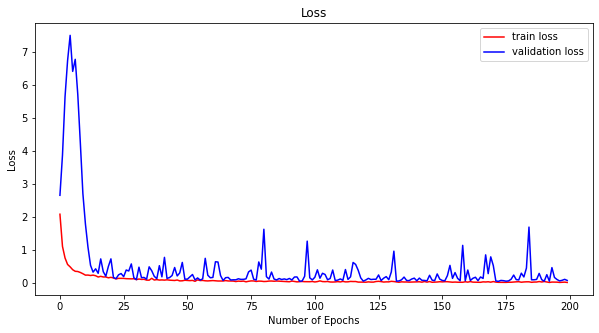

In [87]:
plt.figure(figsize = (10,5))
plt.plot(history2e1.history['loss'],color='r',label="train loss")
plt.plot(history2e1.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [88]:
best_score = min(history2e1.history['val_loss'])
best_epoch= history2e1.history['val_loss'].index(best_score)
best_val_acc=history2e1.history['val_accuracy'][best_epoch]
best_acc=history2e1.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  172
best epoch validation accuracy:  0.9927361011505127
best epoch train accuracy:  0.9959568977355957


In [89]:
#evaluate the network 
score = model2e1.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 8ms/step - loss: 0.3123 - accuracy: 0.9636
Test score:  0.31226563453674316
Test accuracy:  0.9636363387107849


## no pooling

In [90]:
from keras.layers import BatchNormalization

model2e2 = Sequential()

model2e2.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', input_shape = (64,64,1)))
model2e2.add(BatchNormalization())
model2e2.add(Activation('relu'))
model2e2.add(Dropout(0.2))

model2e2.add(Conv2D(filters = 64, kernel_size = (8,8),padding = 'Same'))
model2e2.add(BatchNormalization())
model2e2.add(Activation('relu'))
model2e2.add(Dropout(0.2))

model2e2.add(Conv2D(filters = 128, kernel_size = (1,1),padding = 'Same'))
model2e2.add(BatchNormalization())
model2e2.add(Activation('relu'))
model2e2.add(Dropout(0.2))

model2e2.add(Conv2D(filters = 256, kernel_size = (1,1),padding = 'Same'))
model2e2.add(Activation('relu'))
model2e2.add(BatchNormalization())

model2e2.add(Conv2D(filters = 10, kernel_size = (1,1),padding = 'Same'))
model2e2.add(Activation('softmax'))
model2e2.add(Flatten())

model2e2.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_9 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 64, 64, 64)        131136    
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 64, 64, 64)      